# Histopathologic Notebook


## 1. Dependencies


In [1]:
import sys

sys.modules["IPython"] = None
sys.stderr = sys.stdout

import warnings

warnings.filterwarnings("ignore")

import os

os.environ["PYTHONWARNINGS"] = "ignore"

In [2]:
try:
    from captum.attr import IntegratedGradients
except:
    !pip3 install captum==0.7.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.3 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import models
from torchvision.transforms import v2 as transforms

import multiprocessing as mp

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression

from optuna import logging, create_study
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.exceptions import TrialPruned

logging.set_verbosity(logging.WARNING)

from captum.attr import IntegratedGradients

import numpy as np
import pandas as pd
import tifffile as tiff

import matplotlib.pyplot as plt
import matplotlib as mpl
import textwrap
from tqdm import tqdm

## 2. Data exploration


First we will create a class that allows us to easily read the provided data.


In [4]:
class TifImageDataset(Dataset):

    def __init__(self, imgs_dir, labels_file=None, transforms=None):
        self.imgs_dir = imgs_dir
        if labels_file is None:
            self.ids = np.array([f.split(".")[0] for f in os.listdir(imgs_dir)])
            self.labels = None
        else:
            df = pd.read_csv(labels_file)
            self.ids = df["id"].to_numpy()
            self.labels = df["label"].to_numpy()
        self.transforms = transforms

    def __len__(self):
        return self.ids.shape[0]

    def __getitem__(self, idx):
        image = tiff.imread(os.path.join(self.imgs_dir, self.ids[idx] + ".tif"))
        if self.transforms is not None:
            image = self.transforms(image)
        return (image,) if self.labels is None else (image, self.labels[idx])

Let's take a look at some of the images along with their classification. For this, we will also use a function that shows us the image in question.


In [5]:
def imshow(imgs, titles, max_cols=5):
    n_imgs = len(imgs)
    n_rows = int(np.ceil(n_imgs / max_cols))
    n_cols = n_imgs if n_imgs <= max_cols else max_cols

    _, axes = plt.subplots(nrows=n_rows, ncols=n_cols, squeeze=False)

    for i in range(n_rows):
        for j in range(n_cols):
            if j + n_cols * i < n_imgs:
                axes[i][j].imshow(imgs[j + n_cols * i])
                axes[i][j].set_title(f"{titles[j + n_cols * i]}")
                axes[i][j].set_xticks([])
                axes[i][j].set_yticks([])
            else:
                axes[i][j].axis("off")

    plt.tight_layout()
    plt.show()

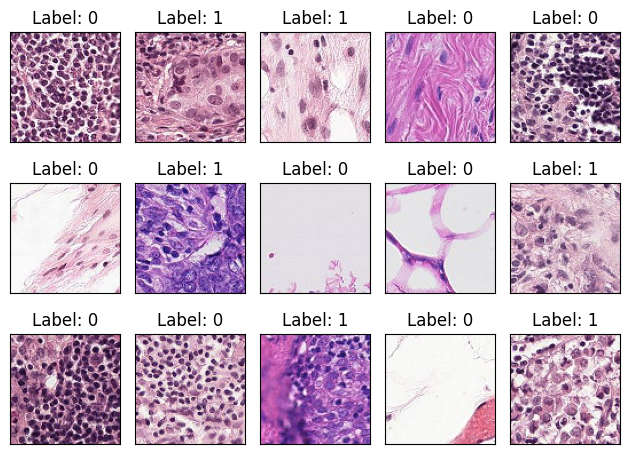

In [6]:
imgs_dir = "../input/histopathologic-cancer-detection/train"
labels_file = "../input/histopathologic-cancer-detection/train_labels.csv"

orig_dataset = TifImageDataset(imgs_dir, labels_file)

imgs, titles = [], []
for idx in range(5, 20):
    img, label = orig_dataset[idx]
    imgs.append(img)
    titles.append(f"Label: {label}")

imshow(imgs, titles)

Apparently the number of positives as well as negatives is the same, let's check it.


Label 0: 59.5%
Label 1: 40.5%


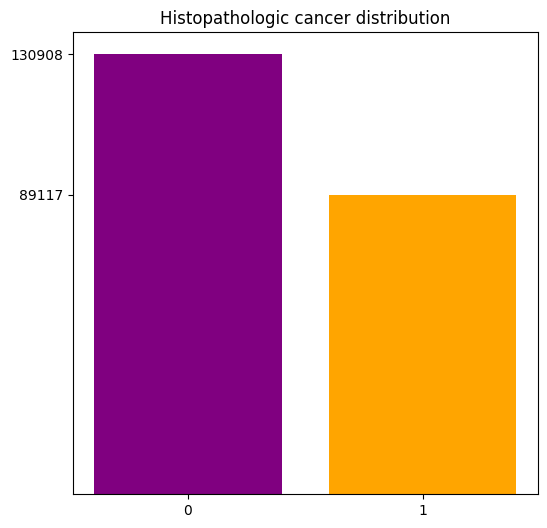

In [7]:
index, values = np.unique(orig_dataset.labels, return_counts=True)

print(f"Label 0: {100 * values[0] / len(orig_dataset):.1f}%")
print(f"Label 1: {100 * values[1] / len(orig_dataset):.1f}%")

plt.figure(figsize=(6, 6))
plt.bar(index, values, color=["purple", "orange"])
plt.xticks(index)
plt.yticks(values)
plt.title("Histopathologic cancer distribution")
plt.show()

As it is not exactly distributed, it will be good to take it into account when training and validating.


## 3. Previous preparation


Before we go through the different techniques used to try to achieve the best percentage, we will introduce auxiliary classes, as well as parameters, common to all of them.



First it will be a class that will help us to train, evaluate and predict. Keep in mind that it will be as generic as possible to be useful in all cases.


In [8]:
class NeuralNetworkTrainer:

    def __init__(
        self, model, loss_f, optimizer, scheduler=None, device=torch.device("cpu")
    ):
        self.model = model
        self.loss_f = loss_f
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device

        self.mtr_ = None
        self.loss_ = None
        self.vmtr_ = None
        self.vloss_ = None
        self.history_ = {"mtr": [], "loss": [], "vmtr": [], "vloss": []}

        self.__probs_metrics = ["roc_auc_score"]

    def execute(
        self,
        dataloader,
        vdataloader=None,
        metric=accuracy_score,
        pv_class=-1,
        epochs=5,
        early_stopper=None,
        verbose=1,
        trial=None,
    ):
        num_batch = len(dataloader)

        progress_bar = None

        for e in range(1, 1 + epochs):

            if verbose > 0:
                progress_bar = tqdm(total=num_batch, unit="batch", desc=f"Epoch {e}")

            self.__train_one_epoch(dataloader, progress_bar)
            self.mtr_, self.loss_ = self.eval(dataloader, metric, True, pv_class)
            self.history_["mtr"].append(self.mtr_)
            self.history_["loss"].append(self.loss_)

            if verbose > 0:
                post = {"mtr": f"{self.mtr_:.4f}", "loss": f"{self.loss_:.4f}"}
                progress_bar.set_postfix(**post)

            if vdataloader:
                self.vmtr_, self.vloss_ = self.eval(vdataloader, metric, True, pv_class)
                self.history_["vmtr"].append(self.vmtr_)
                self.history_["vloss"].append(self.vloss_)

                if verbose > 0:
                    vpost = {"vmtr": f"{self.vmtr_:.4f}", "vloss": f"{self.vloss_:.4f}"}
                    progress_bar.set_postfix(**post, **vpost)

                if early_stopper(self.vloss_):
                    if trial is not None:
                        trial.report(self.vmtr_, e)
                    if verbose > -1:
                        if verbose > 0:
                            progress_bar.close()
                        print(f"Early stop at epoch {e}")
                    break

            if self.scheduler is not None:
                self.scheduler.step()

            if verbose > 0:
                progress_bar.close()

            if trial is not None:
                trial.report(self.vmtr_ if vdataloader else self.mtr_, e)
                if trial.should_prune():
                    raise TrialPruned()

        if verbose > -1:
            print(f"Training: mtr={self.mtr_:.4f}, loss={self.loss_:.4f}")
            if vdataloader:
                print(f"Evaluation: vmtr={self.vmtr_:.4f}, vloss={self.vloss_:.4f}")

        if verbose == 2:
            executed_epochs = range(1, e + 1)
            plt.figure(figsize=(6, 6))
            plt.plot(executed_epochs, self.history_["mtr"], label="mtr")
            plt.plot(executed_epochs, self.history_["loss"], label="loss")
            if vdataloader:
                plt.plot(executed_epochs, self.history_["vmtr"], label="vmtr")
                plt.plot(executed_epochs, self.history_["vloss"], label="vloss")
            plt.title("Metric & Loss History")
            plt.legend()
            plt.show()

        return self

    def __train_one_epoch(self, dataloader, progress_bar):
        self.model.train()

        for data in dataloader:
            data = list(map(lambda x: x.to(self.device), data))

            Xs, y = data[:-1], data[-1]

            pred = self.model(*Xs)
            loss = self.loss_f(pred, y)

            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

            if progress_bar:
                progress_bar.update(1)

    def eval(self, dataloader, metric=accuracy_score, calc_loss=False, pv_class=-1):
        calc_probs = True if metric.__name__ in self.__probs_metrics else False
        data = self.predict(dataloader, True, calc_loss, calc_probs)

        y_pred = data[0] if not calc_probs else data[0][:, pv_class]
        y_true = data[1]
        loss = data[2] if calc_loss else None

        score = metric(y_true, y_pred)

        res = []
        res.append(score)
        if calc_loss:
            res.append(loss)

        return (*res,)

    def predict(self, dataloader, has_target=False, calc_loss=False, calc_probs=False):
        total_loss = 0.0
        all_ys = []
        all_preds = []

        num_batch = len(dataloader)

        self.model.eval()

        with torch.no_grad():
            for data in dataloader:
                data = list(map(lambda x: x.to(self.device), data))
                if has_target:
                    Xs, y = data[:-1], data[-1]
                else:
                    Xs = data

                preds = self.model(*Xs)
                if calc_probs:
                    all_preds.extend(F.softmax(preds, dim=1).cpu().numpy())
                else:
                    all_preds.extend(preds.argmax(dim=1).cpu().numpy())

                if has_target:
                    if calc_loss:
                        total_loss += self.loss_f(preds, y).item()
                    all_ys.extend(y.cpu().numpy())

        res = []
        res.append(np.array(all_preds))
        if has_target:
            res.append(np.array(all_ys))
            if calc_loss:
                res.append(total_loss / num_batch)

        return (*res,)

Also for the realization of the early stop and to avoid overfitting, we will make another auxiliary class to the previous one.


In [9]:
class EarlyStopper:

    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta

        self.counter = 0
        self.min_vloss = np.inf

    def __call__(self, vloss):
        if vloss < self.min_vloss:
            self.counter = 0
            self.min_vloss = vloss

        elif vloss > (self.min_vloss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True

        return False

We will set the GPU as a device, in addition to some hyperparameters that are common (they have been tuned during the creation of the notebook and the same ones have been reached for all cases).


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 256
epochs = 15
learning_rate = 0.001
early_stopper_args = {"patience": 2, "min_delta": 0.001}

We will then read the data but indicating transformations to avoid overfitting in the training set. Note that this is very important since Whole Slide Image has been performed so, even if we split the set in training and validation, data leakage will occur and the performance obtained in validation may vary a lot with respect to the test set. For this reason, the set will be split only once instead of cross-validation. It should also be noted that we have simply applied the transformations without adding new images since the final performance obtained is quite close to 1, the main problem being overfitting, so we save a little computational cost.


In [11]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.RandomChoice(
            [
                transforms.ColorJitter(brightness=0.5),
                transforms.ColorJitter(contrast=0.5),
                transforms.ColorJitter(saturation=0.5),
                transforms.ColorJitter(hue=0.5),
                transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
                transforms.ColorJitter(0.3, 0.3, 0.3, 0.3),
                transforms.ColorJitter(0.5, 0.5, 0.5, 0.5),
            ]
        ),
        transforms.RandomChoice(
            [
                transforms.RandomRotation((0, 0)),
                transforms.RandomHorizontalFlip(p=1),
                transforms.RandomVerticalFlip(p=1),
                transforms.RandomRotation((90, 90)),
                transforms.RandomRotation((180, 180)),
                transforms.RandomRotation((270, 270)),
                transforms.Compose(
                    [
                        transforms.RandomHorizontalFlip(p=1),
                        transforms.RandomRotation((90, 90)),
                    ]
                ),
                transforms.Compose(
                    [
                        transforms.RandomHorizontalFlip(p=1),
                        transforms.RandomRotation((270, 270)),
                    ]
                ),
            ]
        ),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

dataset = TifImageDataset(imgs_dir, labels_file, transform)

train_idx, val_idx = train_test_split(
    np.arange(len(dataset)),
    test_size=0.25,
    shuffle=True,
    stratify=dataset.labels,
)

train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)

train_dataloader = DataLoader(
    train_dataset,
    batch_size,
    shuffle=True,
    num_workers=mp.cpu_count(),
    pin_memory=torch.cuda.is_available(),
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size,
    shuffle=False,
    num_workers=mp.cpu_count(),
    pin_memory=torch.cuda.is_available(),
)

In addition, for the tests performed before the final model, we will train it with part of the total set, to speed up the process.


In [12]:
subset_size = 10000

_, train_idx = train_test_split(
    np.arange(len(dataset)),
    test_size=subset_size / len(dataset),
    shuffle=True,
    stratify=dataset.labels,
)
_, val_idx = train_test_split(
    np.delete(np.arange(len(dataset)), train_idx),
    test_size=0.25 * subset_size / (len(dataset) - subset_size),
    shuffle=True,
    stratify=np.delete(dataset.labels, train_idx),
)

train_subset = Subset(dataset, train_idx)
val_subset = Subset(dataset, val_idx)

train_subloader = DataLoader(
    train_subset,
    batch_size,
    shuffle=True,
    num_workers=mp.cpu_count(),
    pin_memory=torch.cuda.is_available(),
)
val_subloader = DataLoader(
    val_subset,
    batch_size,
    shuffle=False,
    num_workers=mp.cpu_count(),
    pin_memory=torch.cuda.is_available(),
)

## 4. Approaches


## &#160;&#160;&#160;&#160;4.1. Convolutional Neural Network


First we will see a convolutional neural network created and customized from scratch. To do this, we will first create an auxiliary class that will allow us to define a global max pooling that will be used at the end of the convolutional blocks, as well as another class to define these blocks, which will be of the form conv -> relu -> pool -> bn.


In [13]:
class GlobalMaxPooling(nn.Module):

    def __init__(self, *args, **kwargs):
        super().__init__()

    def forward(self, x):
        return torch.amax(x, dim=(2, 3))

In [14]:
class Convolutional2dBlock(nn.Module):

    def __init__(
        self,
        in_ch,
        out_ch,
        kernel,
        stride=1,
        padding=0,
        batch_norm=False,
        pool_type=None,
        pool_size=2,
        pool_stride=1,
        pool_padding=0,
    ):
        super().__init__()

        self.cv = nn.Conv2d(in_ch, out_ch, kernel, stride, padding, bias=not batch_norm)

        self.bn = None
        if batch_norm:
            if "global" in pool_type.__name__.lower():
                self.bn = nn.BatchNorm1d(out_ch)
            else:
                self.bn = nn.BatchNorm2d(out_ch)

        self.pl = None
        if pool_type:
            self.pl = pool_type(pool_size, pool_stride, pool_padding)

    def forward(self, x):
        x = F.relu(self.cv(x))
        if self.pl is not None:
            x = self.pl(x)
        if self.bn is not None:
            x = self.bn(x)
        return x

Obviously, these two auxiliary classes will be generic, but so will be the CNN that we will define below. This is to make it easier to also do a tuning of the network architecture that we will see later.



In general, the proposed architecture will consist of convolutional blocks, taking into account that the last one will have a global pooling, followed by the fc layers.


In [15]:
class CNN(nn.Module):

    def __init__(
        self,
        in_chl,
        out_size,
        cv_args=[(16, 3, 1, 0), (8, 3, 1, 0)],
        bt_norm=[False, False],
        pl_args=[(nn.MaxPool2d, 2, 1, 0), (GlobalMaxPooling,)],
        fc_args=[(8, 0.2)],
    ):
        super().__init__()

        in_chls = [in_chl] + list(map(lambda cv_arg: cv_arg[0], cv_args[:-1]))
        self.conv_blocks = nn.Sequential(
            *[
                Convolutional2dBlock(in_chls[i], *cv_args[i], bt_norm[i], *pl_args[i])
                for i in torch.arange(len(cv_args))
            ]
        )

        flatten = lambda xss: sum(xss, [])
        self.fc = (
            nn.Linear(cv_args[-1][0], out_size)
            if len(fc_args) == 0
            else nn.Sequential(
                nn.Linear(cv_args[-1][0], fc_args[0][0]),
                nn.ReLU(),
                nn.Dropout(fc_args[0][1]),
                *flatten(
                    [
                        [
                            nn.Linear(fc_args[i - 1][0], fc_args[i][0]),
                            nn.ReLU(),
                            nn.Dropout(fc_args[i][1]),
                        ]
                        for i in torch.arange(1, len(fc_args))
                    ]
                ),
                nn.Linear(fc_args[-1][0], out_size),
            )
        )

    def forward(self, x):
        x = self.conv_blocks(x)
        x = self.fc(x)
        return x

Let's run a simple version of the architecture without worrying too much about tuning to see the performance a priori.


Epoch 10: 100%|██████████| 40/40 [00:23<00:00,  1.73batch/s, loss=0.6206, mtr=0.7169, vloss=0.6212, vmtr=0.7114]
Early stop at epoch 10
Training: mtr=0.7169, loss=0.6206
Evaluation: vmtr=0.7114, vloss=0.6212


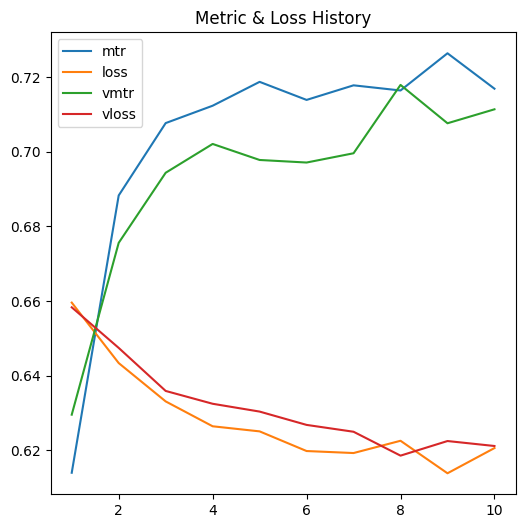

In [16]:
model = CNN(
    in_chl=3,
    out_size=2,
    cv_args=[(8, 2, 1, 1), (16, 2, 1, 1)],
    pl_args=[(nn.MaxPool2d, 2, 2, 0), (GlobalMaxPooling,)],
    bt_norm=[True, True],
    fc_args=[(8, 0.2)],
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.7**epoch)

net = NeuralNetworkTrainer(
    model,
    criterion,
    optimizer,
    scheduler=scheduler,
    device=device,
).execute(
    train_subloader,
    vdataloader=val_subloader,
    metric=roc_auc_score,
    epochs=epochs,
    early_stopper=EarlyStopper(**early_stopper_args),
    verbose=2,
)

In the following we will try to tune some parts of the architecture, but not all, as some parts should work better as indicated below. Note that the number of epochs has been reduced to speed up the process.


In [17]:
def objective(trial):
    n_conv_blocks = trial.suggest_int("n_conv_blocks", 2, 3)

    cv_args = []
    bt_norm = []
    pl_args = []

    for i in range(n_conv_blocks):

        output_channel = trial.suggest_int(f"output_channel_{i}", 16, 128, step=16)
        kernel_size = trial.suggest_int(f"kernel_size_{i}", 3, 5, step=2)
        stride = 1
        padding = "same"
        cv_args.append((output_channel, kernel_size, stride, padding))

        batch_norm = trial.suggest_categorical(f"batch_norm_{i}", [False, True])
        bt_norm.append(batch_norm)

        pool_type = nn.MaxPool2d if i < n_conv_blocks - 1 else GlobalMaxPooling
        pool_kernel_size = 2
        pool_stride = trial.suggest_int(f"pool_stride_{i}", 1, 2)
        pool_padding = 0
        pl_args.append((pool_type, pool_kernel_size, pool_stride, pool_padding))

    n_fc_layers = trial.suggest_int("n_fc_layers", 1, 3)

    fc_args = []

    for i in range(n_fc_layers):

        middle_size = trial.suggest_int(f"middle_size_{i}", 4, 128, step=4)
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.2, 0.5)
        fc_args.append((middle_size, dropout_rate))

    model = CNN(
        in_chl=3,
        out_size=2,
        cv_args=cv_args,
        bt_norm=bt_norm,
        pl_args=pl_args,
        fc_args=fc_args,
    ).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda ep: 0.7**ep)

    net = NeuralNetworkTrainer(
        model,
        criterion,
        optimizer,
        scheduler=scheduler,
        device=device,
    ).execute(
        train_subloader,
        vdataloader=val_subloader,
        metric=roc_auc_score,
        epochs=2,
        early_stopper=EarlyStopper(**early_stopper_args),
        verbose=-1,
        trial=trial,
    )

    return net.vmtr_

Best trial: 3. Best value: 0.839609: 100%|██████████| 10/10 [06:56<00:00, 41.63s/it]
CNN: 0.840 with {'n_conv_blocks': 3, 'output_channel_0': 96, 'kernel_size_0': 5,
	'batch_norm_0': True, 'pool_stride_0': 1, 'output_channel_1': 48, 'kernel_size_1': 3,
	'batch_norm_1': False, 'pool_stride_1': 2, 'output_channel_2': 112, 'kernel_size_2': 5,
	'batch_norm_2': False, 'pool_stride_2': 1, 'n_fc_layers': 2, 'middle_size_0': 88,
	'dropout_rate_0': 0.363603764484654, 'middle_size_1': 124, 'dropout_rate_1':
	0.21732702020626218}


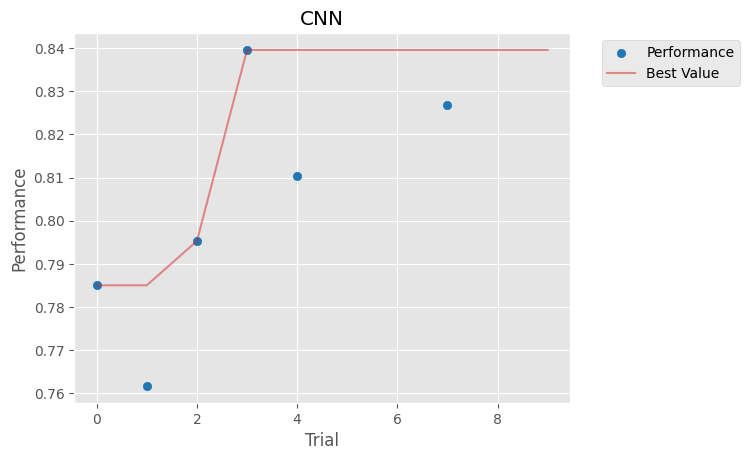

In [18]:
study = create_study(direction="maximize")
study.optimize(objective, n_trials=10, show_progress_bar=True)

output = "CNN: %.3f with %s" % (
    study.best_trial.values[0],
    study.best_trial.params,
)
print("\n".join(textwrap.wrap(output, 88, subsequent_indent="\t")))
plot_optimization_history(study, target_name="Performance")
plt.title("CNN")
plt.show()

The results obtained are (taking into account that the randomness has not been fixed):



- CNN: 0.843 with {'n_conv_blocks': 3, 'output_channel_0': 96, 'kernel_size_0': 5, 'batch_norm_0': True, 'pool_stride_0': 2, 'output_channel_1': 112, 'kernel_size_1': 3, 'batch_norm_1': True, 'pool_stride_1': 1, 'output_channel_2': 128, 'kernel_size_2': 3, 'batch_norm_2': False, 'pool_stride_2': 1, 'n_fc_layers': 3, 'middle_size_0': 96, 'dropout_rate_0': 0.44303403757732845, 'middle_size_1': 80, 'dropout_rate_1': 0.36195297000746773, 'middle_size_2': 64, 'dropout_rate_2': 0.29013193947373683}



Let's see how it performs with all epochs (also, we go back to the previous matplotlib settings since optuna modifies them).


In [19]:
mpl.rcParams.update(mpl.rcParamsDefault)

Epoch 10: 100%|██████████| 40/40 [01:11<00:00,  1.79s/batch, loss=0.4180, mtr=0.8875, vloss=0.4277, vmtr=0.8783]
Early stop at epoch 10
Training: mtr=0.8875, loss=0.4180
Evaluation: vmtr=0.8783, vloss=0.4277


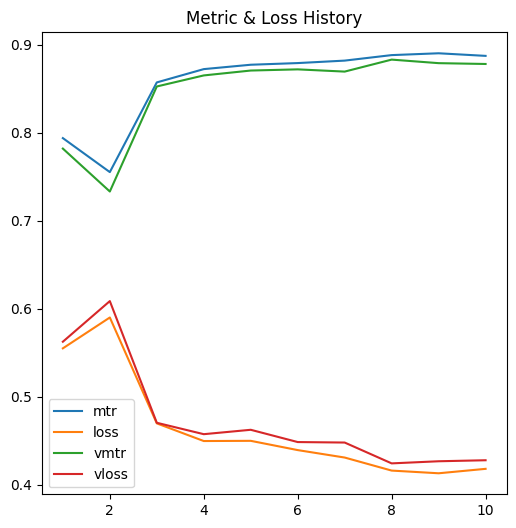

In [20]:
model = CNN(
    in_chl=3,
    out_size=2,
    cv_args=[
        (96, 5, 1, "same"),
        (112, 3, 1, "same"),
        (128, 3, 1, "same"),
    ],
    bt_norm=[True, True, False],
    pl_args=[
        (nn.MaxPool2d, 2, 2, 0),
        (nn.MaxPool2d, 2, 1, 0),
        (GlobalMaxPooling,),
    ],
    fc_args=[(96, 0.45), (80, 0.35), (64, 0.3)],
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.7**epoch)

cnn = NeuralNetworkTrainer(
    model,
    criterion,
    optimizer,
    scheduler=scheduler,
    device=device,
).execute(
    train_subloader,
    vdataloader=val_subloader,
    metric=roc_auc_score,
    epochs=epochs,
    early_stopper=EarlyStopper(**early_stopper_args),
    verbose=2,
)

## &#160;&#160;&#160;&#160;4.2. ResNet18


Next we will test some pre-trained models. The first one will be ResNet. The version with the best results, i.e. ResNet18, was selected. Note that only the fc layers will be trained to avoid overfitting.


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 169MB/s]
Epoch 7: 100%|██████████| 40/40 [00:24<00:00,  1.61batch/s, loss=0.4444, mtr=0.8623, vloss=0.4651, vmtr=0.8517]
Early stop at epoch 7
Training: mtr=0.8623, loss=0.4444
Evaluation: vmtr=0.8517, vloss=0.4651


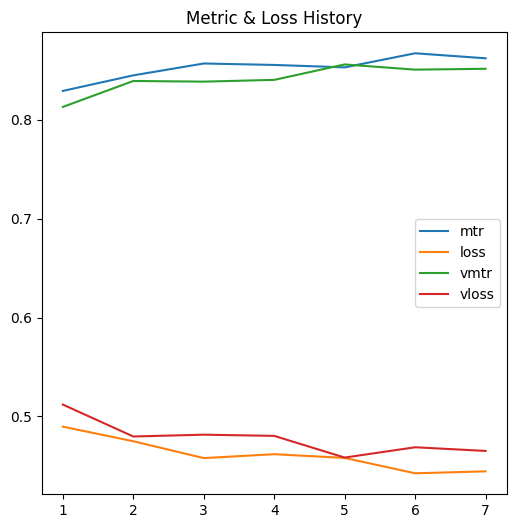

In [21]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, 2)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.7**epoch)

resnet = NeuralNetworkTrainer(
    model,
    criterion,
    optimizer,
    scheduler=scheduler,
    device=device,
).execute(
    train_subloader,
    vdataloader=val_subloader,
    metric=roc_auc_score,
    epochs=epochs,
    early_stopper=EarlyStopper(**early_stopper_args),
    verbose=2,
)

## &#160;&#160;&#160;&#160;4.3. VGG16


The next one will be VGG, which in this case, the version chosen, is VGG16.


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 199MB/s]
Epoch 8: 100%|██████████| 40/40 [00:26<00:00,  1.50batch/s, loss=0.3948, mtr=0.8995, vloss=0.4057, vmtr=0.8886]
Early stop at epoch 8
Training: mtr=0.8995, loss=0.3948
Evaluation: vmtr=0.8886, vloss=0.4057


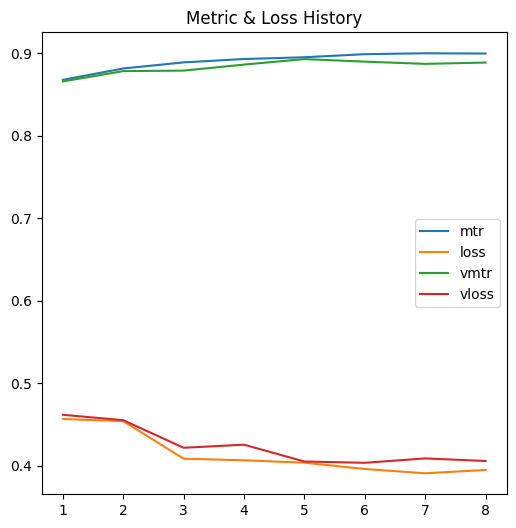

In [22]:
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 2)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.7**epoch)

vgg = NeuralNetworkTrainer(
    model,
    criterion,
    optimizer,
    scheduler=scheduler,
    device=device,
).execute(
    train_subloader,
    vdataloader=val_subloader,
    metric=roc_auc_score,
    epochs=epochs,
    early_stopper=EarlyStopper(**early_stopper_args),
    verbose=2,
)

## &#160;&#160;&#160;&#160;4.4. Stacking ensemble


Finally, we will test how the three previous models work in an ensemble, specifically, stacking ensemble.


In [23]:
pred_train_cnn, y_train = cnn.predict(train_subloader, has_target=True)
pred_train_res, y_train = resnet.predict(train_subloader, has_target=True)
pred_train_vgg, y_train = vgg.predict(train_subloader, has_target=True)

pred_val_cnn, y_val = cnn.predict(val_subloader, has_target=True)
pred_val_res, y_val = resnet.predict(val_subloader, has_target=True)
pred_val_vgg, y_val = vgg.predict(val_subloader, has_target=True)

In [24]:
stacked_train_preds = np.vstack((pred_train_cnn, pred_train_res, pred_train_vgg))
stacked_val_preds = np.vstack((pred_val_cnn, pred_val_res, pred_val_vgg))

In [25]:
meta_learner = LogisticRegression().fit(stacked_train_preds.T, y_train)

In [26]:
positive_probs = meta_learner.predict_proba(stacked_val_preds.T)[:, 1]
roc_auc_score(y_val, positive_probs)

0.8665502469244808

## 5. Final results


Therefore, the best results obtained are from the CNN and the VGG, the last one being slightly superior. However, as it takes considerably longer to train than the CNN, we will opt for this one, as the difference in performance is not so significant.



We will now train with the entire data set.


Epoch 15: 100%|██████████| 645/645 [07:48<00:00,  1.38batch/s, loss=0.2285, mtr=0.9673, vloss=0.2320, vmtr=0.9663]
Training: mtr=0.9673, loss=0.2285
Evaluation: vmtr=0.9663, vloss=0.2320


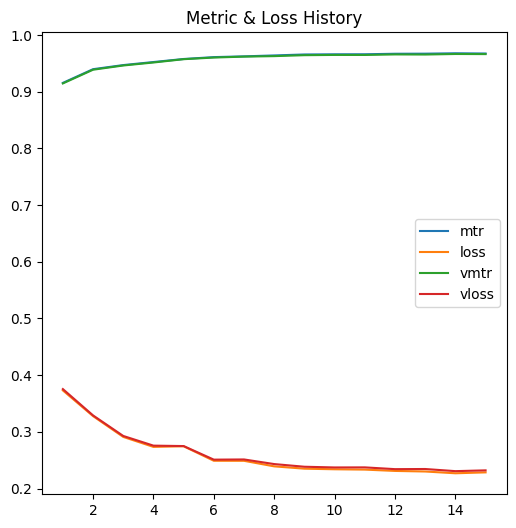

In [27]:
model = CNN(
    in_chl=3,
    out_size=2,
    cv_args=[
        (96, 5, 1, "same"),
        (112, 3, 1, "same"),
        (128, 3, 1, "same"),
    ],
    bt_norm=[True, True, False],
    pl_args=[
        (nn.MaxPool2d, 2, 2, 0),
        (nn.MaxPool2d, 2, 1, 0),
        (GlobalMaxPooling,),
    ],
    fc_args=[(96, 0.45), (80, 0.35), (64, 0.3)],
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.7**epoch)

cnn_full = NeuralNetworkTrainer(
    model,
    criterion,
    optimizer,
    scheduler=scheduler,
    device=device,
).execute(
    train_dataloader,
    vdataloader=val_dataloader,
    metric=roc_auc_score,
    epochs=epochs,
    early_stopper=EarlyStopper(**early_stopper_args),
    verbose=2,
)

Since this is already the final model, we can detail the results a little more, for example, by showing the ROC curve, which is the metric we are using.


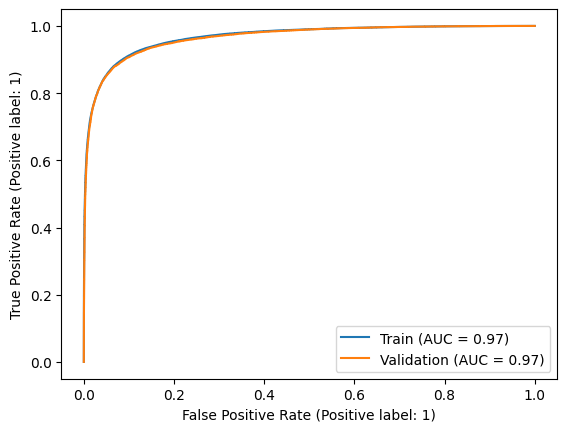

In [28]:
t_preds, t_y = cnn_full.predict(train_dataloader, has_target=True, calc_probs=True)
v_preds, v_y = cnn_full.predict(val_dataloader, has_target=True, calc_probs=True)

positive_train_preds = t_preds[:, 1]
positive_val_preds = v_preds[:, 1]

_, ax = plt.subplots(nrows=1, ncols=1)
RocCurveDisplay.from_predictions(t_y, positive_train_preds, ax=ax, name="Train")
RocCurveDisplay.from_predictions(v_y, positive_val_preds, ax=ax, name="Validation")
plt.show()

We can also study which pixels have been the most relevant when making the prediction for each image.


In [29]:
idx = 7

img, label = orig_dataset[idx]
preprocess = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
img_tensor = preprocess(img).unsqueeze(0).to(device)

model.eval()
attributions = IntegratedGradients(model).attribute(
    img_tensor,
    baselines=torch.ones(img_tensor.shape, device=device),
    target=1,
)

In [30]:
def visualize_attributions(img, attributions):
    attributions = attributions.squeeze().cpu().detach().numpy()
    attributions = np.transpose(attributions, (1, 2, 0))

    _, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].imshow(img)
    ax[0].set_title("Original Image")
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].imshow(np.mean(np.abs(attributions), axis=2), cmap="inferno")
    ax[1].set_title("Integrated Gradients")
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    plt.tight_layout()
    plt.show()

True: 1 / Predicted: 1


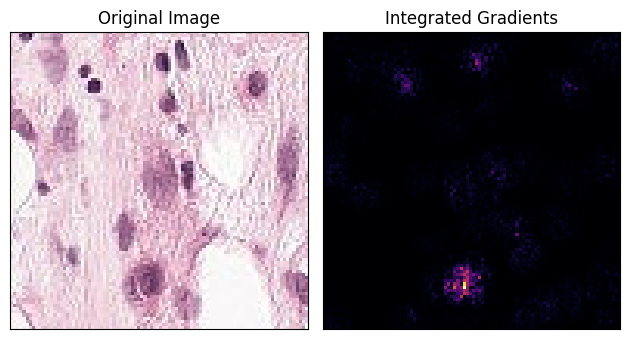

In [31]:
pred = np.argmax(model(img_tensor)[0].cpu().detach().numpy())

print(f"True: {label} / Predicted: {pred}")
visualize_attributions(img, attributions)

Finally, we create the file with the predictions on the test set.


In [32]:
img_dir = "../input/histopathologic-cancer-detection/test"

test_dataset = TifImageDataset(img_dir, transforms=preprocess)

test_dataloader = DataLoader(
    test_dataset,
    batch_size,
    shuffle=False,
    num_workers=mp.cpu_count(),
    pin_memory=torch.cuda.is_available(),
)

probs = cnn_full.predict(test_dataloader, calc_probs=True)[0]

pd.DataFrame(
    list(zip(test_dataset.ids, probs[:, 1])),
    columns=["id", "label"],
).to_csv("submission.csv", index=False)